In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from MemSE.train_test_loop import accuracy
from MemSE.utils import count_parameters
from MemSE.model_load import load_model
from MemSE.dataset import get_dataloader
from MemSE.network_manipulations import conv_to_fc
from MemSE.MemSE import MemSE
from MemSE.MemristorQuant import MemristorQuant

device = torch.device('cpu')

train_loader, valid_loader, test_loader, nclasses, input_shape = get_dataloader('CIFAR10', bs=4)
criterion = nn.CrossEntropyLoss().to(device)
model = load_model('smallest_vgg', nclasses).to(device)
print(count_parameters(model))
model = conv_to_fc(model, input_shape).to(device)
print(count_parameters(model))
batch, target = next(iter(train_loader))
batch, target = batch.to(device), target.to(device)
original_output = model(batch)
original_acc = accuracy(original_output, target)
print(f'Original acc is {original_acc}')


quanter = MemristorQuant(model, std_noise=1e-2, N=128, Gmax=2.)
quanter.quant()
quanted_output = model(batch)
quanted_acc = accuracy(quanted_output, target)
print(f'Quanted acc is {quanted_acc}')

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading model checkpoint
4030
8061088
Original acc is [tensor(50.)]
Quanted acc is [tensor(75.)]


In [2]:
memse = MemSE(model, quanter, input_bias=None)
mses, means, varis = memse.mse_forward(batch)

W is
Parameter containing:
tensor([[-0.6128, -0.7404, -1.3787,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.6128, -0.7404,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.6128,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5362,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0213,  0.5362,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.9702,  1.0213,  0.5362]],
       requires_grad=True)
torch.Size([4, 2048])
tensor(4.4256, grad_fn=<MeanBackward0>)
torch.Size([4, 2048])
tensor(4.4256, grad_fn=<MeanBackward0>)
torch.Size([4, 2048, 2048])
tensor(0.0022, grad_fn=<MeanBackward0>)
IN LOG
torch.Size([4, 2, 32, 32, 2, 32, 32])
tensor(0.0022, grad_fn=<MeanBackward0>)
IN LOG
torch.Size([4, 2, 32, 32, 2, 32, 32])
tensor(-0.0495, grad_fn=<MeanBackward0>)
IN LOG
torch.Size([4, 2, 16, 16, 2, 16, 16])
tensor(-0.0495, grad_fn=<MeanBackward0>)
W is
Parameter containing:
tensor([[ 0.1277,  2.7319, -1.1489, 

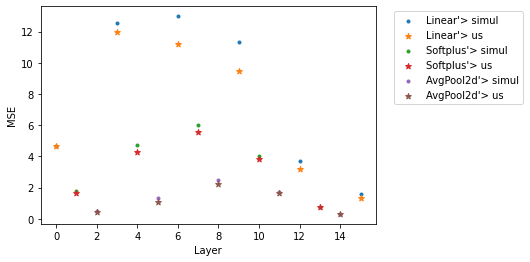

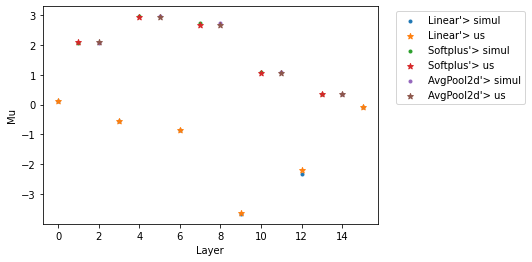

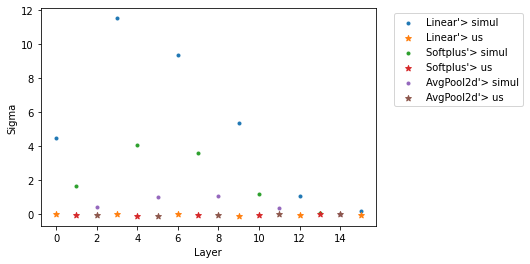

In [3]:
def plot_comp_dict(dict_, ylabel, yscale='log', legend=True):
    for type_, sub_dict in dict_['sim'].items():
        us_sub_dict = dict_['us'].get(type_)
        plt.scatter(sub_dict.keys(), sub_dict.values(), marker='.', label=str(type_).split('.')[-1]+' simul')
        plt.scatter(us_sub_dict.keys(), us_sub_dict.values(), marker='*', label=str(type_).split('.')[-1]+' us')
    if legend:
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.yscale(yscale)
    plt.xlabel('Layer')
    plt.ylabel(ylabel)
    plt.show()

plot_comp_dict(mses, 'MSE', 'linear')
plot_comp_dict(means, 'Mu', 'linear')
plot_comp_dict(varis, 'Gamma', 'linear')